In [16]:
import mpmath as mp
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from mpmath import *
from mpl_toolkits.mplot3d import Axes3D
mp.dps = 15; mp.pretty = True

In [17]:
######################## Functions ########################

In [111]:
# Normalise X value with choosen range
def xnorm (x,maxrange,minrange):
    # Separate the dimensions
    n=[]
    for j in range(x.shape[1]):
        temp=[]
        for i in range(x.shape[0]):
            temp.append(x[i][j])
        rex=(maxrange-minrange)/(np.max(temp)-np.min(temp))*(np.array(temp)-np.min(temp))+minrange
        n.append(rex)
    a=[]
    for i in range(x.shape[0]):
        r=[]
        for j in range(x.shape[1]):
            r.append(n[j][i])
        a.append(r)
    return np.array(a)
# Normalise Y value with choosen range
def ynorm (func,maxrange,minrange):
    rex=(maxrange-minrange)/(np.max(func)-np.min(func))*(np.array(func)-np.min(func))+minrange
    return rex
# Decode Normalised integrated value
def decode(func,x,maxrange,minrange,inte):
    v={}
    for j in range(x.shape[1]):
        temp=[]
        for i in range(x.shape[0]):
            temp.append(x[i][j])
        v[j]=np.max(temp)-np.min(temp)
    product=1
    for i in range(x.shape[1]):
        product=product*v[i]
    vs=product
    vss=(maxrange-minrange)**x.shape[1]
    f=np.max(func)-np.min(func)
    yy=maxrange-minrange
    return vs*f*inte/(vss*yy)+(np.min(func)-f/yy*minrange)*vs
# Initial function
def init(dim):
    # number of function dimension
    dim = dim
    # training set of N
    N = 3000*dim**3
    N = 300
    # random x grid
    x = np.random.random((N,dim))
    # set the maximum dimension
    MAX_DIM=20
    # set the random variables of u and c
    np.random
    u = np.random.random((dim,))
    cs = np.random.random((MAX_DIM,))
    cs = cs[:x.shape[1]]
    return dim, N, x, u, cs
# function for fitting
# y value
def oscil(x):
    arg = np.dot(x,cs)
    arg += u[0] * 2 * np.pi
    return np.cos(arg)
def prod(x):
    temp={}
    for i in range(x.shape[1]):
        temp2=[]
        for j in range(x.shape[0]):
            temp2.append(x[j][i])
        temp[i]=(cs[i]**(-2)+(temp2-u[i])**2)**(-1)
    product=1
    for i in range(x.shape[1]):
        product=product*temp[i]
    return product
# function graph
def graph(dim,x,y):
    if dim == 1:
        plt.scatter(x,y)
        plt.show()
    elif dim == 2:
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(projection='3d')
        x1=[j[0] for j in x]
        x2=[j[1] for j in x]
        ax.scatter(x1, x2, y)
        plt.show()
    elif dim == 3:
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(projection='3d')
        x1 = [j[0] for j in x]
        x2 = [j[1] for j in x]
        x3 = [j[2] for j in x]
        img = ax.scatter(x1, x2, x3, c=y, cmap=plt.hot())
        fig.colorbar(img)
        plt.show()
    elif dim == 4:
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(projection='3d')
        x1 = [j[0] for j in x]
        x2 = [j[1] for j in x]
        x3 = [j[2] for j in x]
        x4 = [j[3]*30 for j in x]
        img = ax.scatter(x1, x2, x3, c=y,s=x4, cmap=plt.hot())
        fig.colorbar(img)
        plt.show()
# number of nodes (k) tunable parameter k1,k2
def node(dim,N):
    k1 = 4.33
    k2 = 16
    #k = math.floor(((np.log10(N)**(-k1))*(k2*N/(dim+2))))
    k = math.floor(10*dim*np.log10(N)**1.5)
    return k
# weight and bias of input and output
def coe(mlpr):
    weight_input = []
    weight_output = mlpr.coefs_[1]
    bias_input = mlpr.intercepts_[0]
    bias_output = mlpr.intercepts_[1]
    for i in range(dim):
        weight_input.append(mlpr.coefs_[0][i])
    return weight_input, weight_output, bias_input, bias_output
# weight and bias of input and output
def coe2(mlpr):
    weight_input = []
    weight_output = mlpr.coefs_[1]
    bias_input = mlpr.intercepts_[0]
    bias_output = mlpr.intercepts_[1]
    for i in range(dim):
        weight_input.append(mlpr.coefs_[0][i])
    return weight_input, weight_output, bias_input, bias_output



# sign of sigmoid integration
def addIndex(l):
    ret = []
    for v in l:
        ret.append(v+[0])
        ret.append(v+[1])
    return ret 

def sigs(l):
    return int((-1)**(sum(l)-len(l)))

def lims(n):
    ret = [[]]
    for i in range(n):
        ret = addIndex(ret)
    if n%2==0:
        signs = [sigs(x) for x in ret]
    else:
        signs = [-1*sigs(x) for x in ret]
    return ret, signs

# numerical calculation of integral
al = 0
be = 1
def integral(node,dim):
    if dim == 1:
        temp = []
        for i in range(node):
            po = (polylog(dim,-np.exp(-bias_input[i]-weight_input[0][i]*al))
                  -polylog(dim,-np.exp(-bias_input[i]-weight_input[0][i]*be)))       
            temp.append(weight_output[i]*((be-al)+po/weight_input[0][i]))
        result = bias_output*(be-al)+sum(temp)
        return result[0]
    else :
        temp=[]
        poly =[]
        for i in range(len(lims(dim)[1])):
            weight=[]
            for j in range(len(lims(dim)[0][i])):
                arg = weight_input[j]*lims(dim)[0][i][j]
                weight.append(arg)
            po=[]
            for j in range(node):
                po.append(lims(dim)[1][i]*polylog(dim,-np.exp(-bias_input-sum(weight))[j]))
            poly.append(np.array(po))
        product=1
        for j in range(len(weight_input)):
            product = product*weight_input[j]
        temp.append(1+sum(poly)/product)
        result=bias_output+np.dot(temp,weight_output)
    return float(result[0][0])
# integral for identity activation
def integral2(node,dim):
    arg=bias_input2*1+sum(weight_input2)*(1/2)
    temp=[]
    for i in range(node):
        temp.append(weight_output2[i]*arg[i])
        result=bias_output2+sum(temp)
    return float(result[0])
# integral for relu activation
def integral3(node,dim):
    arg=bias_input3*1+sum(weight_input3)*(1/2)
    for i in range(node):
        temp=[]
        if arg[i] > 0:
            temp.append(weight_output3[i]*arg[i])
        else :
            temp.append(0)
        re=bias_output3+sum(temp)
    return float(re[0])
# integral for relu activation
def integral4(node,dim):
    arg=bias_input3*1+(1/math.factorial(dim+1))*sum(np.array(weight_input3)**(dim+1))
    for i in range(node):
        temp=[]
        if arg[i] > 0:
            temp.append(weight_output3[i]*arg[i])
        else :
            temp.append(0)
        re=bias_output3+sum(temp)
    return float(re[0])


# analytical integral value
def symbolicval(ndiff, nfix):
    arest = cs[ndiff:]
    adiff = cs[:ndiff]
    norm = 2**ndiff*np.prod(np.sin(adiff/2))/np.prod(adiff)
    arg = 2*np.pi*u[0] + sum(adiff)/2
    if nfix == 0:
        F = norm*np.cos(arg)
    else:
        #def F(x):
            #return norm*np.cos(arg+np.dot(x[ndiff:],arest))
        xt=x.T[ndiff:]
        F = norm*np.cos(arg+np.dot(xt.T,arest))
    return F
def symbolicval2(ndiff, nfix):
    temp=[]
    for i in range(ndiff):
        temp.append(cs[i]*(np.arctan(cs[i]*u[i])+np.arctan(cs[i]-cs[i]*u[i])))
    product=1
    for i in range(ndiff):
        product=product*temp[i]
    if nfix ==0:
        F=product
    else:
        temp={}
        for i in range(x.shape[1]):
            temp2=[]
            for j in range(x.shape[0]):
                temp2.append(x[j][i])
            temp[i]=(cs[i]**(-2)+(temp2-u[i])**2)**(-1)
        product2=1
        for i in range(nfix):
            product2=product2*temp[i+nfix]
            F=product2
        return F*prod(x)
    return F

In [112]:
################### Initialize value ######################

size of x, cs and u
(300, 3)
(3,)
(3,)
original function graph(dim<=4)


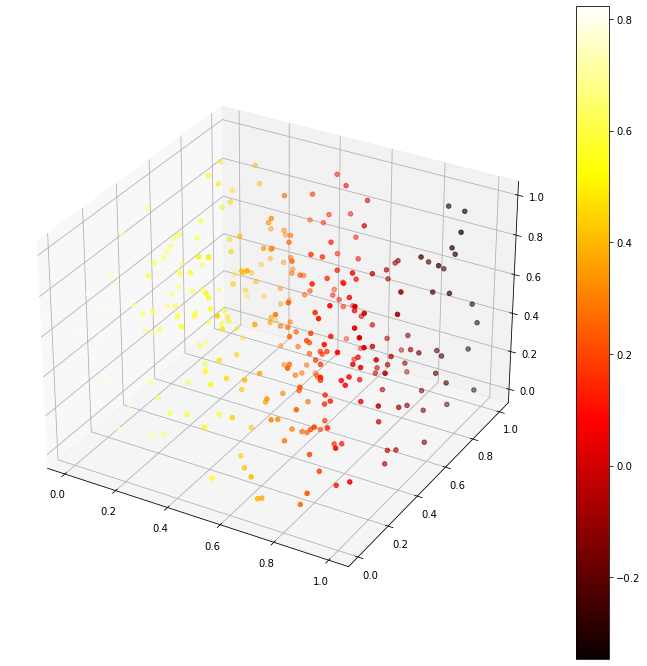

number of nodes
116
[ 2.37678349e-01  5.20011171e-01  2.38245909e-01  1.83705373e-01
  7.94294390e-01  6.34502139e-01  1.85370243e-01 -3.05508439e-02
  4.66620509e-01  4.15873623e-01  4.45175028e-01 -2.81116481e-01
  2.98623806e-01 -9.77329004e-02 -1.88162035e-01  4.62733064e-02
  6.01976613e-01  2.49879471e-01  8.64667001e-02  1.57028693e-01
  3.07608739e-01 -4.66295272e-03  1.16648701e-01 -1.23883481e-01
  1.41330307e-01  1.10750569e-01  3.37025609e-01  3.20169874e-01
 -6.67655560e-02  5.22419229e-01  9.18813748e-02 -8.51578637e-02
  6.95521116e-02  1.01216558e-01  5.66358255e-01  3.39456365e-01
 -2.85991154e-01  3.71860929e-01  2.62626307e-01  1.50784659e-01
  5.70721918e-01  7.23774190e-01  8.22502446e-01  1.37604872e-01
  6.25129140e-01  1.99147323e-01  4.49992708e-01  2.34618104e-01
  2.26816723e-01  6.29459852e-01  6.07104390e-01  3.06093059e-01
  1.69372350e-01  3.48722407e-01  3.13031148e-01  2.05407228e-01
  7.91886568e-01  7.27275223e-02  6.90198356e-01  4.10904756e-02
 -1.5

In [157]:
# Original values
dim, N, x, u, cs = init(3)
y = oscil(x)
#y = prod(x)
# test and validation divide 95%
trainx, testx, trainy, testy = train_test_split(x, y, test_size = 0.05)
k = node(dim,N)

print('size of x, cs and u')
print(x.shape)
print(cs.shape)
print(u.shape)
print('original function graph(dim<=4)')
graph(dim,x,y)
print('number of nodes')
print(k)
print(y)

In [114]:
# Normalised value
ys = ynorm(oscil(x),1,0)
xs = xnorm(x,1,0)
# test and validation divide 95%
trainxs, testxs, trainys, testys = train_test_split(xs, ys, test_size = 0.05)

In [23]:
#################### Run multi layer perceptron #####################

In [8]:
start = timeit.default_timer()
# mlpregression with logistic activation
mlp_reg = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic', n_iter_no_change=100,
                       solver = 'adam', learning_rate_init=0.001,
                       learning_rate ='adaptive', tol=1e-10)
# fitting NN
mlp_reg.fit(trainx, trainy)
print('convergence: ',len(mlp_reg.loss_curve_))
print('loss: ', mlp_reg.best_loss_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

convergence:  116
loss:  2.2819890036498295e-05
Time:  26.938668957999997


In [19]:
start = timeit.default_timer()
# mlpregression with logistic activation with changed hyperparameter sgd
mlp_reg_sgd = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic', learning_rate ='adaptive',
                       solver = 'sgd', momentum=0.99, n_iter_no_change=100,
                       learning_rate_init=0.0005, tol=1e-10)
# fitting NN
mlp_reg_sgd.fit(trainx, trainy)
print('convergence: ',len(mlp_reg_sgd.loss_curve_))
print('loss: ', mlp_reg_sgd.best_loss_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

convergence:  450
loss:  5.0429421328078655e-05
Time:  101.86619570799985


/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [158]:
start = timeit.default_timer()
# mlpregression with logistic activation with changed hyperparameter lbfgs
mlp_reg_lb = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic',
                       solver = 'lbfgs', early_stopping=True,
                       learning_rate_init=0.0005, tol=1e-10)
# fitting NN
mlp_reg_lb.fit(trainx, trainy)
print('Convergence: ',mlp_reg_lb.n_iter_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

Convergence:  15
Time:  0.08439212499069981


In [21]:
start = timeit.default_timer()
# mlpregression with identity activation
mlp_reg_id = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 1000000000,activation = 'identity',
                       solver = 'adam', learning_rate ='adaptive', n_iter_no_change=100,
                       learning_rate_init=0.0005, tol=1e-10)
# fitting NN
mlp_reg_id.fit(trainx, trainy)
print('convergence: ',len(mlp_reg_id.loss_curve_))
print('loss: ', mlp_reg_id.best_loss_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

convergence:  30
loss:  4.9396889795563605e-05
Time:  4.7820343749999665


/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [22]:
start = timeit.default_timer()
# mlpregression with identity activation with changed hyperparameter sgd
mlp_reg_id_sgd = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 1000000000,activation = 'identity', n_iter_no_change=100,
                       solver = 'sgd', momentum=0.99, learning_rate ='adaptive',
                       learning_rate_init=0.0005, tol=1e-10)
# fitting NN
mlp_reg_id_sgd.fit(trainx, trainy)
print('convergence: ',len(mlp_reg_id_sgd.loss_curve_))
print('loss: ', mlp_reg_id_sgd.best_loss_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

convergence:  11
loss:  4.927035879643772e-05
Time:  2.007895292000285


/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [9]:
start = timeit.default_timer()
# mlpregression with identity activation with changed hyperparameter lbfgs
mlp_reg_id_lb = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 1000000000,activation = 'identity',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
# fitting NN
mlp_reg_id_lb.fit(trainx, trainy)
print('Convergence: ',mlp_reg_id_lb.n_iter_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

Convergence:  9
Time:  6.788873290999987


In [131]:
start = timeit.default_timer()
# mlpregression with relu activation
mlp_reg_re = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 1000000000,activation = 'relu', n_iter_no_change=100,
                       solver = 'adam', learning_rate ='adaptive',
                       learning_rate_init=0.0005, tol=1e-10)
# fitting NN
mlp_reg_re.fit(trainx, trainy)
print('convergence: ',len(mlp_reg_re.loss_curve_))
print('loss: ', mlp_reg_re.best_loss_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

convergence:  1643
loss:  6.522073959060402e-07
Time:  183.03904545799742


In [132]:
start = timeit.default_timer()
# mlpregression with relu activation with changed hyperparameter sgd
mlp_reg_re_sgd = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 1000000000,activation = 'relu', n_iter_no_change=100,
                       solver = 'sgd', momentum=0.99, learning_rate ='adaptive',
                       learning_rate_init=0.0005, tol=1e-10)
# fitting NN
mlp_reg_re_sgd.fit(trainx, trainy)
print('convergence: ',len(mlp_reg_re_sgd.loss_curve_))
print('loss: ', mlp_reg_re_sgd.best_loss_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

convergence:  4888
loss:  1.8650564456558822e-06
Time:  1042.0541801660002


/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [133]:
start = timeit.default_timer()
# mlpregression with relu activation with changed hyperparameter lbfgs
mlp_reg_re_lb = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 1000000000,activation = 'relu',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
# fitting NN
mlp_reg_re_lb.fit(trainx, trainy)
print('Convergence: ',mlp_reg_re_lb.n_iter_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

KeyboardInterrupt: 

In [24]:
start = timeit.default_timer()
# Normalised value running
# mlpregression with logistic activation
mlp_reg3 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000000,activation = 'logistic', n_iter_no_change=100,
                       solver = 'adam', learning_rate ='adaptive',
                       learning_rate_init=0.001, tol=1e-10)
# fitting NN
mlp_reg3.fit(trainxs, trainys)
print('convergence: ',len(mlp_reg3.loss_curve_))
print('loss: ', mlp_reg3.best_loss_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

convergence:  7
loss:  0.00021190016381095018
Time:  1.7810515840001244


/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [25]:
start = timeit.default_timer()
# Normalised value running with changed hyperparameter sgd
# mlpregression with logistic activation
mlp_reg3_sgd = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000000,activation = 'logistic', n_iter_no_change=100,
                       solver = 'sgd', momentum=0.99, learning_rate ='adaptive',
                       learning_rate_init=0.001, tol=1e-10)
# fitting NN
mlp_reg3_sgd.fit(trainxs, trainys)
print('convergence: ',len(mlp_reg3_sgd.loss_curve_))
print('loss: ', mlp_reg3_sgd.best_loss_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

convergence:  15
loss:  0.00019827157863386231
Time:  3.545771500000228


/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [10]:
start = timeit.default_timer()
# Normalised value running with changed hyperparameter lbfgs
# mlpregression with logistic activation
mlp_reg3_lb = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000000,activation = 'logistic',
                       solver = 'lbfgs',
                       learning_rate_init=0.001, tol=1e-10)
# fitting NN
mlp_reg3_lb.fit(trainxs, trainys)
print('Convergence: ',mlp_reg3_lb.n_iter_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

Convergence:  18
Time:  36.73443829200002


In [113]:
#start = timeit.default_timer()
# mlpregression with 2 layer identity activation
#mlp_reg_id2 = MLPRegressor(hidden_layer_sizes=(k,k,),max_iter = 1000000000,activation = 'identity', n_iter_no_change=100,solver = 'adam', learning_rate ='adaptive',learning_rate_init=0.0005, tol=1e-10)
# fitting NN
#mlp_reg_id2.fit(trainx, trainy)
#print('Max iteration: ',mlp_reg_id2.max_iter)
#print('convergence: ',len(mlp_reg_id2.loss_curve_))
#print('loss: ', mlp_reg_id2.best_loss_)
#stop = timeit.default_timer()
#print('Time: ', stop - start)  

In [85]:
#print(mlp_reg_id2.coefs_[1])
#print('------------------------------------------------------------------')
#print(mlp_reg_id2.intercepts_)

In [86]:
####################### Prediction ###################

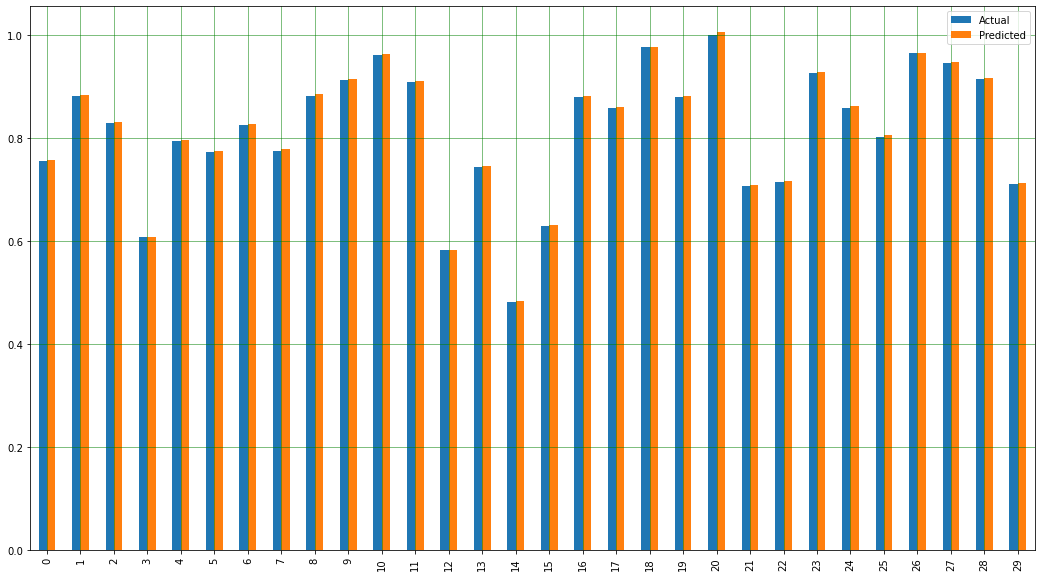

Mean Absolute Error: 0.0019762641908219643
Mean Squared Error: 5.478081421479874e-06
Root Mean Squared Error: 0.0023405301582077242


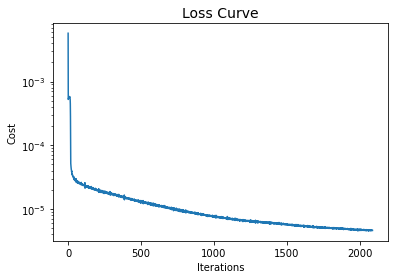

In [231]:
# predict the fitting
y_pred = mlp_reg.predict(testx)
df_temp = pd.DataFrame({'Actual': testy, 'Predicted': y_pred})
df_temp.head()
# graph of predict and validation
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(18,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
# MSE and Loss
print('Mean Absolute Error:', metrics.mean_absolute_error(testy, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(testy, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testy, y_pred)))
plt.plot(mlp_reg.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.yscale('log')
plt.show()

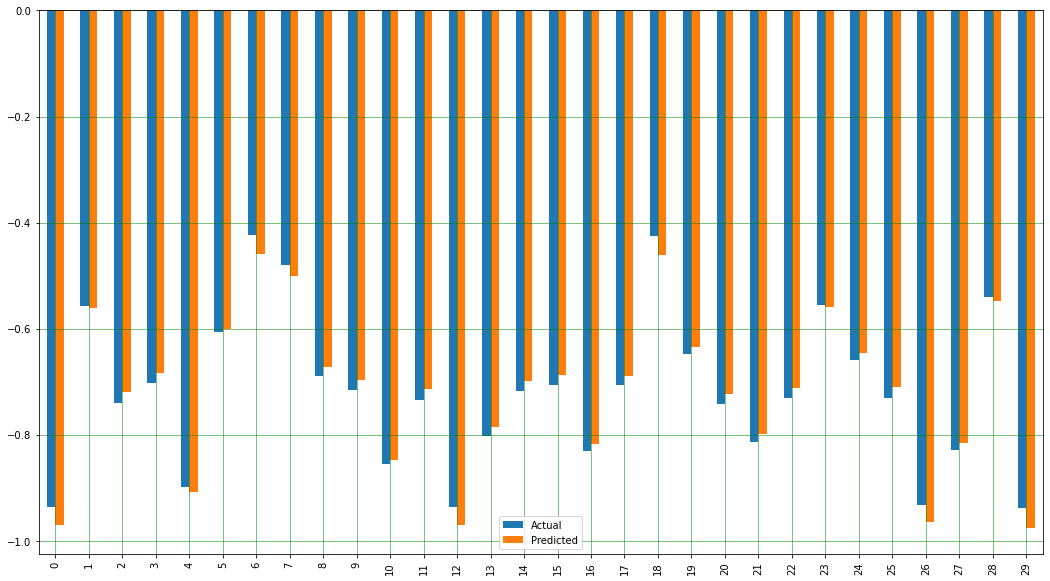

Mean Absolute Error: 0.01706428435742462
Mean Squared Error: 0.0004001542437642436
Root Mean Squared Error: 0.0200038557224412


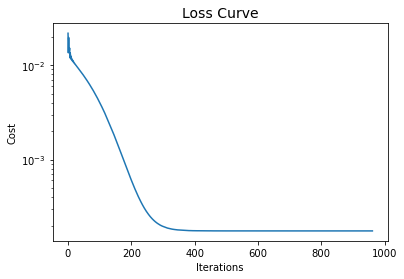

In [53]:
# predict the fitting with changed hyperparameter
y_pred = mlp_reg_sgd.predict(testx)
df_temp = pd.DataFrame({'Actual': testy, 'Predicted': y_pred})
df_temp.head()
# graph of predict and validation
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(18,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
# MSE and Loss
print('Mean Absolute Error:', metrics.mean_absolute_error(testy, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(testy, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testy, y_pred)))
plt.plot(mlp_reg_sgd.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.yscale('log')
plt.show()

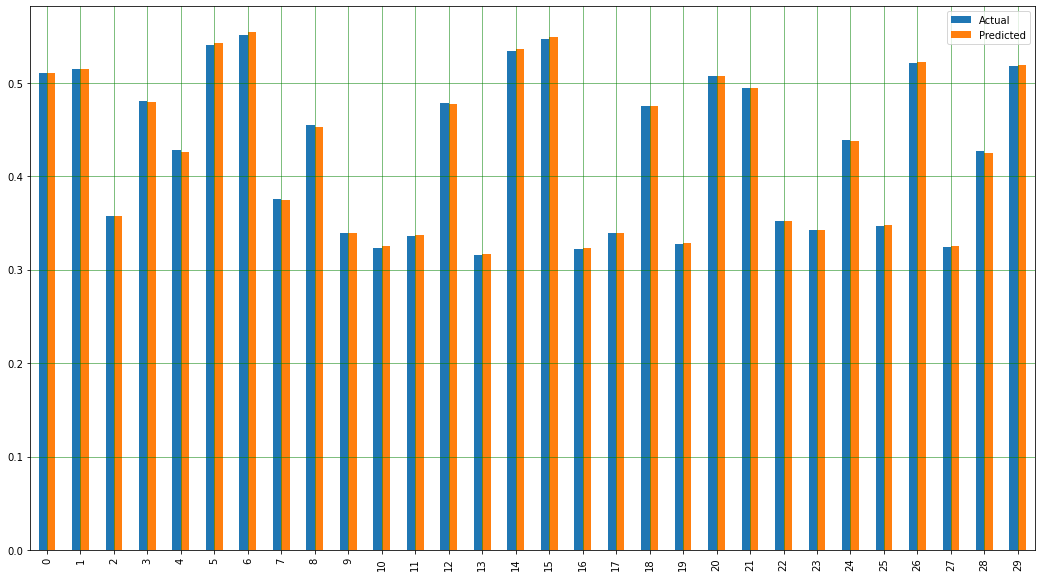

Mean Absolute Error: 0.0010778114540147725
Mean Squared Error: 1.6520745815286039e-06
Root Mean Squared Error: 0.0012853305339594963


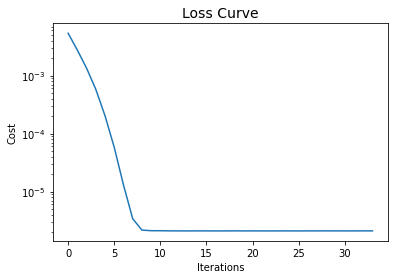

In [595]:
# predict the fitting
y_pred = mlp_reg_id.predict(testx)
df_temp = pd.DataFrame({'Actual': testy, 'Predicted': y_pred})
df_temp.head()
# graph of predict and validation
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(18,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
# MSE and Loss
print('Mean Absolute Error:', metrics.mean_absolute_error(testy, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(testy, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testy, y_pred)))
plt.plot(mlp_reg_id.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.yscale('log')
plt.show()

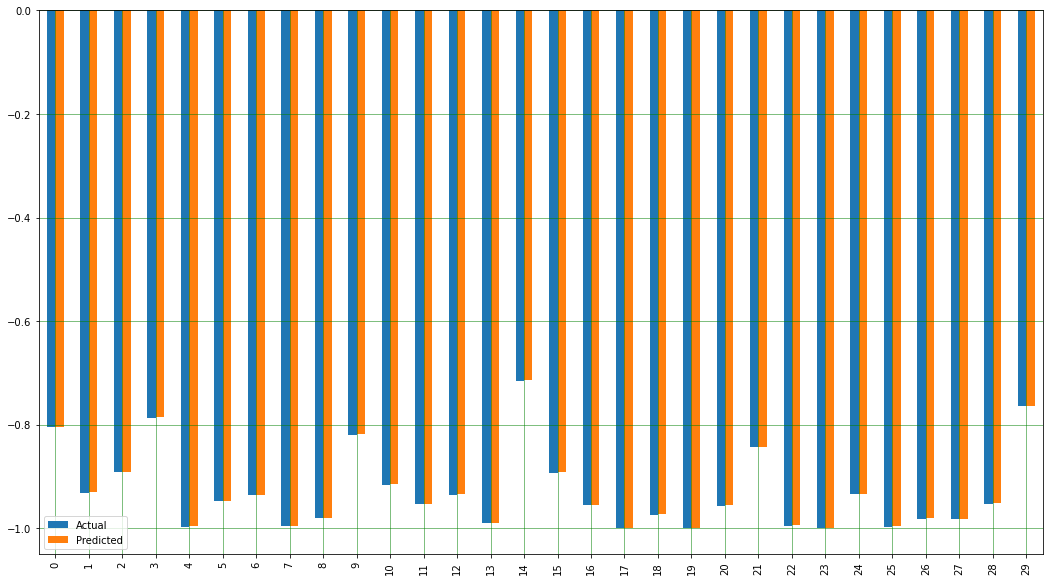

Mean Absolute Error: 0.001073768810857139
Mean Squared Error: 1.291563083743879e-06
Root Mean Squared Error: 0.001136469570091465


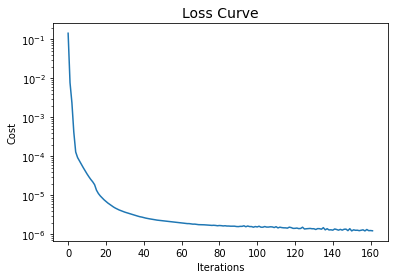

In [363]:
# predict the fitting
y_pred = mlp_reg_re.predict(testx)
df_temp = pd.DataFrame({'Actual': testy, 'Predicted': y_pred})
df_temp.head()
# graph of predict and validation
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(18,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
# MSE and Loss
print('Mean Absolute Error:', metrics.mean_absolute_error(testy, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(testy, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testy, y_pred)))
plt.plot(mlp_reg_re.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.yscale('log')
plt.show()

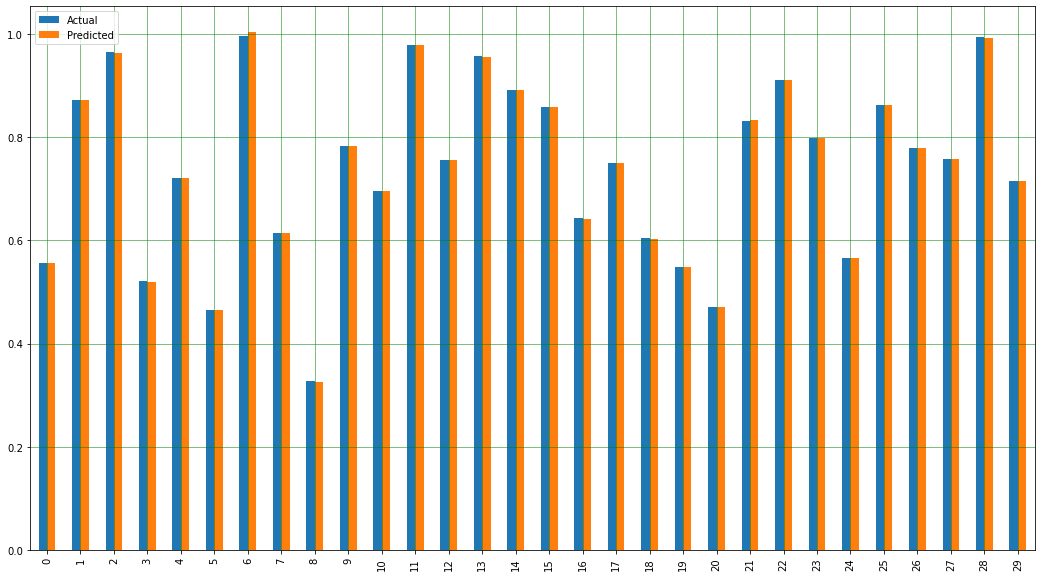

Mean Absolute Error: 0.0007553708118004195
Mean Squared Error: 1.5907271538785176e-06
Root Mean Squared Error: 0.0012612403236015402


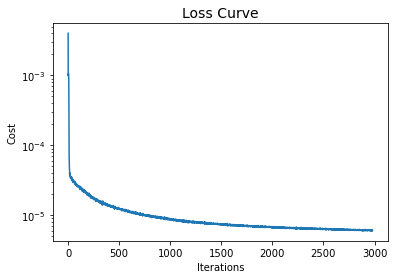

In [232]:
# predict the fitting of normalised value
y_preds = mlp_reg3.predict(testxs)
df_temps = pd.DataFrame({'Actual': testys, 'Predicted': y_preds})
df_temps.head()
# graph of predict and validation
df_temps = df_temps.head(30)
df_temps.plot(kind='bar',figsize=(18,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
# MSE and Loss
print('Mean Absolute Error:', metrics.mean_absolute_error(testys, y_preds))  
print('Mean Squared Error:', metrics.mean_squared_error(testys, y_preds))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testys, y_preds)))
plt.plot(mlp_reg3.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.yscale('log')
plt.show()

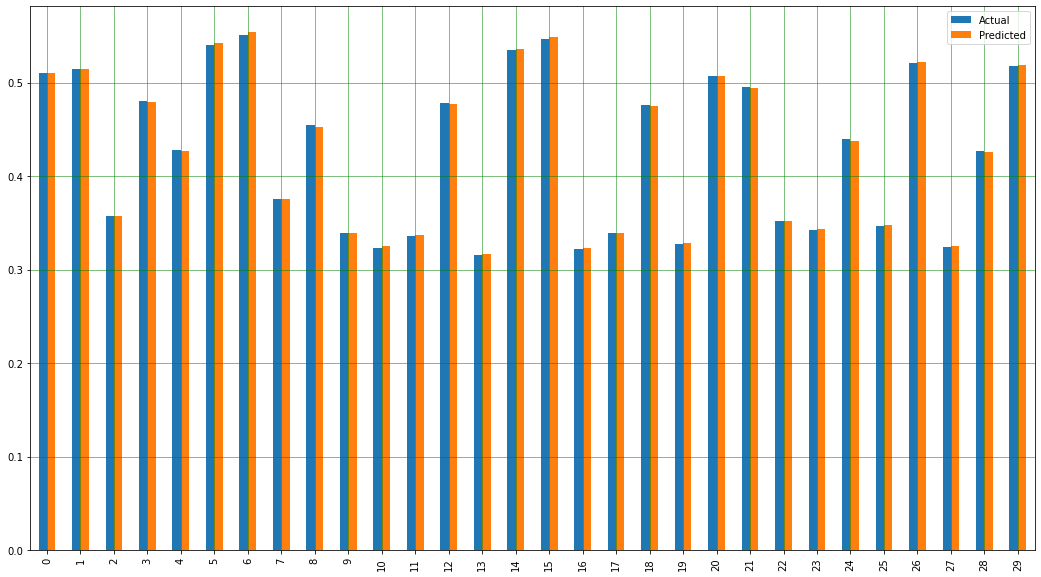

Mean Absolute Error: 0.0010815139829033057
Mean Squared Error: 1.647110379007967e-06
Root Mean Squared Error: 0.0012833979815349433


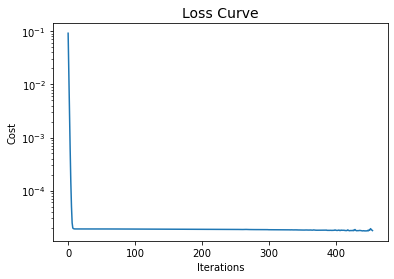

In [576]:
# predict the fitting with 2 layered identity activation
y_pred = mlp_reg_id2.predict(testx)
df_temp = pd.DataFrame({'Actual': testy, 'Predicted': y_pred})
df_temp.head()
# graph of predict and validation
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(18,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
# MSE and Loss
print('Mean Absolute Error:', metrics.mean_absolute_error(testy, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(testy, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testy, y_pred)))
plt.plot(mlp_reg_id2.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.yscale('log')
plt.show()

In [9]:
###################### Integration ######################

In [25]:
# Integrate value of analytic Oscillatory
sy=symbolicval(dim,0)
print('Analytic_Oscil: ',sy)
# Integrate value of analytic Product peak
sy2=symbolicval2(dim,0)
print('Analytic_Prod: ',sy2)

# Integrate value of sigmoid activation
#weight_input, weight_output, bias_input, bias_output = coe(mlp_reg)
#sig=integral(k,dim)
#print('Sigmoid: ',sig)
# Integrate value of sigmoid activation with changed hyperparameter sgd
#weight_input, weight_output, bias_input, bias_output = coe(mlp_reg_sgd)
#sig_sgd=integral(k,dim)
#print('Sigmoid_sgd: ',sig_sgd)
# Integrate value of sigmoid activation with changed hyperparameter lbfgs
weight_input, weight_output, bias_input, bias_output = coe(mlp_reg_lb)
sig_lb=integral(k,dim)
print('Sigmoid_lbsfg: ',sig_lb)

# Integrate value of identity activation
#weight_input2, weight_output2, bias_input2, bias_output2 = coe(mlp_reg_id)
#id1=integral2(k,dim)
#print('Identity: ',id1)
# Integrate value of identity activation with changed hyperparameter sgd
#weight_input2, weight_output2, bias_input2, bias_output2 = coe(mlp_reg_id_sgd)
#id1_sgd=integral2(k,dim)
#print('Identity_sgd: ',id1_sgd)
# Integrate value of identity activation with changed hyperparameter lbfgs
weight_input2, weight_output2, bias_input2, bias_output2 = coe(mlp_reg_id_lb)
id1_lb=integral2(k,dim)
print('Identity_lbsfg: ',id1_lb)

# Integrate value of relu activation
#weight_input3, weight_output3, bias_input3, bias_output3 = coe(mlp_reg_re)
#re1=integral3(k,dim)
#print('Relu: ',re1)
# Integrate value of relu activation
#weight_input3, weight_output3, bias_input3, bias_output3 = coe(mlp_reg_re)
#re2=integral4(k,dim)
#print('Relu2: ',re2)

# Integrate value of sigmoid activation on nomalised value
#weight_input, weight_output, bias_input, bias_output = coe(mlp_reg3)
#norm=decode(oscil(x),x,1,0,integral(k,dim))
#print('Normalise_sigmoid: ',norm)
# Integrate value of sigmoid activation on nomalised value with changed hyperparameter sgd
#weight_input, weight_output, bias_input, bias_output = coe(mlp_reg3_sgd)
#norm_sgd=decode(oscil(x),x,1,0,integral(k,dim))
#print('Normalise_sigmoid_sgd: ',norm_sgd)
# Integrate value of sigmoid activation on nomalised value with changed hyperparameter lbsfg
weight_input, weight_output, bias_input, bias_output = coe(mlp_reg3_lb)
norm_lb=decode(oscil(x),x,1,0,integral(k,dim))
print('Normailise_sigmoid_lbsfg: ',norm_lb)

Analytic_Oscil:  0.29585012074689165
Analytic_Prod:  0.18836246196545642
Sigmoid_lbsfg:  0.2958410797526047


NameError: name 'mlp_reg_id_lb' is not defined

In [12]:
#print('Sigmoid Error(%): ',(abs(sig-sy)/abs(sy))*100)
#print('Sigmoid_sgd Error(%): ',(abs(sig_sgd-sy)/abs(sy))*100)
print('Sigmoid_lbsfg Log-Error(%): ',-np.log10(abs((sig_lb-sy)/sy)))
#print('Identity Error(%): ',(abs(id1-sy)/abs(sy))*100)
#print('Identity_sgd Error(%): ',(abs(id1_sgd-sy)/abs(sy))*100)
print('Identity_lbsfg Log-Error(%): ',-np.log10(abs((id1_lb-sy)/sy)))
#print('Relu Error(%): ',(abs(re1-sy)/abs(sy))*100)
#print('Relu2 Error(%): ',(abs(re2-sy)/abs(sy))*100)
#print('Norm_sig Error(%): ',(abs(norm-sy)/abs(sy))*100)
#print('Norm_sig_sgd Error(%): ',(abs(norm_sgd-sy)/abs(sy))*100)
print('Norm_sig_lbsfg Log-Error(%): ',-np.log10(abs((norm_lb-sy)/sy)))

Sigmoid_lbsfg Log-Error(%):  10.400336560411207
Identity_lbsfg Log-Error(%):  8.151461246103846
Norm_sig_lbsfg Log-Error(%):  7.929146399823324


In [152]:
##################### Data size _ correct digit check ##########################

In [253]:
# correct digits in 2 dimension
dim2={}
dig2={}
Ns=[]
dim, N, x, u, cs = init(2)
y = oscil(x)
trainx, testx, trainy, testy = train_test_split(x, y, test_size = 0.05)
for i in range(6):
    N=10**(i+1)
    Ns.append(N)
    #k2 = node(dim,N)
    k2 =60
    print(k2)
    mlp_reg2 = MLPRegressor(hidden_layer_sizes=(k2,),
                       max_iter = 1000000000,activation = 'logistic',
                       solver = 'adam',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg2.fit(trainx, trainy)
    weight_input, weight_output, bias_input, bias_output = coe(mlp_reg2)
    cal=integral(k2,dim).astype(float)
    dim2[i+1]=cal
    sym=symbolicval(dim,0).astype(float)
    print((abs(sym-cal)/abs(sym)))
    dig2[i+1]=abs(np.log10((abs(sym-cal)/abs(sym))[0][0]))

60
[[0.0005449]]
60
[[0.00018149]]
60
[[0.00215678]]
60
[[0.00164038]]
60
[[0.0013071]]
60
[[0.00064916]]


In [254]:
mlp_reg2.max_iter

1000000000

0.4340632913396333
{1: array([[0.43429981]]), 2: array([[0.43414207]]), 3: array([[0.43312711]]), 4: array([[0.43335126]]), 5: array([[0.43463065]]), 6: array([[0.43434507]])}
{1: 3.2636867584058713, 2: 3.741154048039125, 3: 2.666194962878369, 4: 2.785054964326199, 5: 2.883692074465697, 6: 3.1876480377453156}


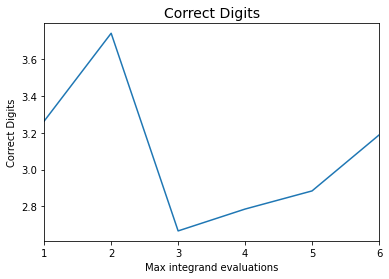

In [255]:
print(symbolicval(dim,0))
print(dim2)
print(dig2)
plt.plot(np.log10(Ns),dig2.values())
plt.title("Correct Digits", fontsize=14)
plt.xlabel('Max integrand evaluations')
plt.ylabel('Correct Digits')
plt.xlim([1,6])
#plt.ylim([0,7])
plt.show()

In [ ]:
######################### Improvement ########################

In [266]:
# node number finding
result1={}
nodes=[]
for i in range(20):
    result=[]
    k=math.floor((i+1)*20*np.sqrt(dim))
    nodes.append(k)
    # mlpregression with logistic activation
    mlp_reg1 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic',
                       solver = 'adam',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg1.fit(trainx, trainy)
    weight_input, weight_output, bias_input, bias_output = coe(mlp_reg1)
    result.append(len(mlp_reg1.loss_curve_))
        
    # mlpregression with logistic activation
    mlp_reg2 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic',
                       solver = 'adam',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg2.fit(trainx, trainy)
    weight_input, weight_output, bias_input, bias_output = coe(mlp_reg2)
    result.append(len(mlp_reg2.loss_curve_))
        
    # mlpregression with logistic activation
    mlp_reg3 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic',
                       solver = 'adam',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg3.fit(trainx, trainy)
    weight_input, weight_output, bias_input, bias_output = coe(mlp_reg3)
    result.append(len(mlp_reg3.loss_curve_))
        
    # mlpregression with logistic activation
    mlp_reg4 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic',
                       solver = 'adam',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg4.fit(trainx, trainy)
    weight_input, weight_output, bias_input, bias_output = coe(mlp_reg4)
    result.append(len(mlp_reg4.loss_curve_))
        
    # mlpregression with logistic activation
    mlp_reg5 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic',
                       solver = 'adam',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg5.fit(trainx, trainy)
    weight_input, weight_output, bias_input, bias_output = coe(mlp_reg5)
    result.append(len(mlp_reg5.loss_curve_))
    result1[k]=list(result)
    print(i+1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


{40: [401, 344, 321, 413, 415], 80: [287, 311, 421, 305, 278], 120: [326, 133, 242, 227, 251], 160: [14, 14, 14, 194, 13], 200: [14, 13, 14, 14, 14], 240: [14, 14, 13, 13, 14], 280: [14, 14, 117, 14, 14], 320: [13, 14, 13, 14, 14], 360: [13, 13, 100, 13, 14], 400: [14, 13, 14, 13, 14], 440: [13, 13, 13, 13, 14], 480: [13, 13, 13, 13, 13], 520: [13, 13, 13, 13, 13], 560: [13, 13, 13, 13, 13], 600: [13, 13, 13, 13, 13], 640: [13, 13, 13, 13, 13], 680: [13, 13, 13, 13, 14], 720: [13, 13, 13, 13, 13], 760: [13, 13, 13, 13, 13], 800: [13, 13, 13, 13, 13]}


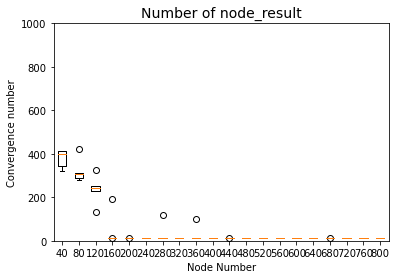

In [267]:
fig, ax = plt.subplots()
print(result1)
ax.boxplot(result1.values())
ax.set_xticklabels(result1.keys())
plt.title("Number of node_result", fontsize=14)
plt.xlabel('Node Number')
plt.ylabel('Convergence number')
plt.ylim([0,1000])
plt.show()

In [268]:
start = timeit.default_timer()
# several fitting
result1={}
num=[]
for i in range(20):
    result=[]
    num.append(i+1)
    # mlpregression with logistic activation
    mlp_reg1 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg1.fit(trainx, trainy)
    weight_input, weight_output, bias_input, bias_output = coe(mlp_reg1)
    result.append(integral(k,dim))
        
    # mlpregression with logistic activation
    mlp_reg2 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg2.fit(trainx, trainy)
    weight_input, weight_output, bias_input, bias_output = coe(mlp_reg2)
    result.append(integral(k,dim))
        
    # mlpregression with logistic activation
    mlp_reg3 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg3.fit(trainx, trainy)
    weight_input, weight_output, bias_input, bias_output = coe(mlp_reg3)
    result.append(integral(k,dim))
        
    # mlpregression with logistic activation
    mlp_reg4 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg4.fit(trainx, trainy)
    weight_input, weight_output, bias_input, bias_output = coe(mlp_reg4)
    result.append(integral(k,dim))
        
    # mlpregression with logistic activation
    mlp_reg5 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg5.fit(trainx, trainy)
    weight_input, weight_output, bias_input, bias_output = coe(mlp_reg5)
    result.append(integral(k,dim))
    result1[i+1]=list(result)
    print(i+1)
stop = timeit.default_timer()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


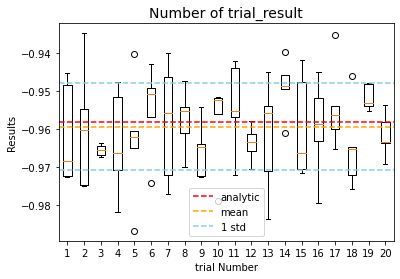

-0.9581544220017255
-0.959369622759728
0.0113964009772243
0.00126827234744005
Time:  5744.003998459026


In [269]:
ave=[]
std=[]
for i in range(len(result1.keys())):
    ave.append(np.mean(result1[i+1]))
for i in range(len(result1.keys())):
    std.append(result1[i+1])
    
fig, ax = plt.subplots()
ax.boxplot(result1.values())
ax.set_xticklabels(result1.keys())
plt.title("Number of trial_result", fontsize=14)
plt.xlabel('trial Number')
plt.ylabel('Results')
plt.axhline(y=symbolicval(dim,0), color='red', linestyle='--', label='analytic')
plt.axhline(y=np.mean(ave), color='orange', linestyle='--', label='mean')
plt.axhline(y=np.mean(ave)+np.std(std), color='skyblue', linestyle='--', label='std')
plt.axhline(y=np.mean(ave)-np.std(std), color='skyblue', linestyle='--')
labels = ["analytic", "mean","1 std"]
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles = handles, labels = labels)
plt.show()
print(symbolicval(dim,0))
print(np.mean(ave))
print(np.std(std))
print(abs(symbolicval(dim,0)-np.mean(ave))/abs(symbolicval(dim,0)))
print('Time: ', stop - start)  

In [270]:
start = timeit.default_timer()
# several fitting identity
result={}
num=[]
for i in range(20):
    result=[]
    num.append(i+1)
    # mlpregression with logistic activation
    mlp_reg1 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'identity',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg1.fit(trainx, trainy)
    weight_input2, weight_output2, bias_input2, bias_output2 = coe(mlp_reg1)
    result.append(integral2(k,dim))
    
    # mlpregression with logistic activation
    mlp_reg2 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'identity',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg2.fit(trainx, trainy)
    weight_input2, weight_output2, bias_input2, bias_output2 = coe(mlp_reg2)
    result.append(integral2(k,dim))
    
    # mlpregression with logistic activation
    mlp_reg3 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'identity',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg3.fit(trainx, trainy)
    weight_input2, weight_output2, bias_input2, bias_output2 = coe(mlp_reg3)
    result.append(integral2(k,dim))
    
    # mlpregression with logistic activation
    mlp_reg4 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'identity',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg4.fit(trainx, trainy)
    weight_input2, weight_output2, bias_input2, bias_output2 = coe(mlp_reg4)
    result.append(integral2(k,dim))
    
    # mlpregression with logistic activation
    mlp_reg5 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'identity',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg5.fit(trainx, trainy)
    weight_input2, weight_output2, bias_input2, bias_output2 = coe(mlp_reg5)
    result.append(integral2(k,dim))
    result1[i+1]=list(result)
    print(i+1)
stop = timeit.default_timer()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


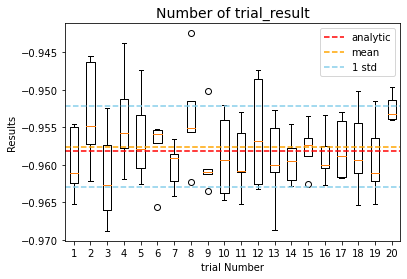

-0.9581544220017255
-0.9575979103729917
0.005416533562418337
0.0005808162191342706
Time:  2181.630711916019


In [271]:
ave=[]
std=[]
for i in range(len(result1.keys())):
    ave.append(np.mean(result1[i+1]))
for i in range(len(result1.keys())):
    std.append(result1[i+1])
    
fig, ax = plt.subplots()
ax.boxplot(result1.values())
ax.set_xticklabels(result1.keys())
plt.title("Number of trial_result", fontsize=14)
plt.xlabel('trial Number')
plt.ylabel('Results')
plt.axhline(y=symbolicval(dim,0), color='red', linestyle='--', label='analytic')
plt.axhline(y=np.mean(ave), color='orange', linestyle='--', label='mean')
plt.axhline(y=np.mean(ave)+np.std(std), color='skyblue', linestyle='--', label='std')
plt.axhline(y=np.mean(ave)-np.std(std), color='skyblue', linestyle='--')
labels = ["analytic", "mean","1 std"]
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles = handles, labels = labels)
plt.show()
print(symbolicval(dim,0))
print(np.mean(ave))
print(np.std(std))
print(abs(symbolicval(dim,0)-np.mean(ave))/abs(symbolicval(dim,0)))
print('Time: ', stop - start)  

In [63]:
# several fitting identity
result_sig=[]
result_id=[]
error_sig=[]
error_id=[]
result=[]
num=[]
for i in range(200):
    MAX_DIM=20
    np.random
    u = np.random.random((dim,))
    cs = np.random.random((MAX_DIM,))
    cs = cs[:x.shape[1]]
    y = oscil(x)
    trainx, testx, trainy, testy = train_test_split(x, y, test_size = 0.05)
    sy=symbolicval(dim,0)
    result.append(sy)

    num.append(i+1)
    # mlpregression with logistic activation
    mlp_reg1 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg1.fit(trainx, trainy)
    weight_input, weight_output, bias_input, bias_output = coe(mlp_reg1)
    inte_sig=integral(k,dim)
    result_sig.append(inte_sig)
    error_sig.append(-np.log10(abs((sy-inte_sig)/sy)))
    
    # mlpregression with logistic activation
    mlp_reg2 = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'identity',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
    # fitting NN
    mlp_reg2.fit(trainx, trainy)
    weight_input2, weight_output2, bias_input2, bias_output2 = coe(mlp_reg2)
    inte_id=integral2(k,dim)
    result_id.append(inte_id)
    error_id.append(-np.log10(abs((sy-inte_id)/sy)))
    if (i+1)%10 == 0:
        print(i+1)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


In [13]:
print(np.log10(10))
print(np.log(10))

1.0
2.302585092994046


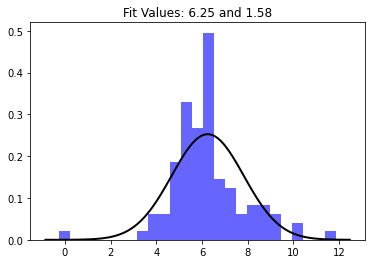

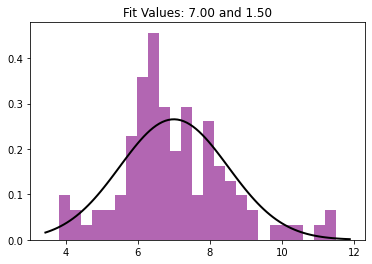

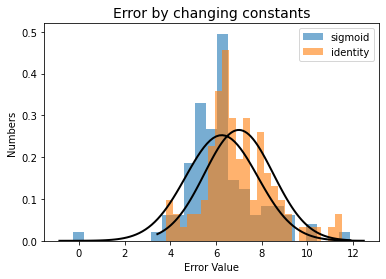

In [59]:
from scipy.stats import norm
mu_sig, std_sig = norm.fit(error_sig) 
plt.hist(error_sig, bins=25, density=True, alpha=0.6, color='b')
xmin_sig, xmax_sig = plt.xlim()
x_sig = np.linspace(xmin_sig, xmax_sig, 100)
p_sig = norm.pdf(x_sig, mu_sig, std_sig)
plt.plot(x_sig, p_sig, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu_sig, std_sig)
plt.title(title)
plt.show()

mu_id, std_id = norm.fit(error_id) 
plt.hist(error_id, bins=25, density=True, alpha=0.6, color='purple')
xmin_id, xmax_id = plt.xlim()
x_id = np.linspace(xmin_id, xmax_id, 100)
p_id = norm.pdf(x_id, mu_id, std_id)
plt.plot(x_id, p_id, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu_id, std_id)
plt.title(title)
plt.show()

fig, ax = plt.subplots()
plt.hist(error_sig, bins=25, density=True, alpha=0.6, label='sigmoid')
plt.plot(x_sig, p_sig, 'k', linewidth=2)
plt.hist(error_id, bins=25, density=True, alpha=0.6, label='identity')
plt.plot(x_id, p_id, 'k', linewidth=2)
plt.title("Error by changing constants", fontsize=14)
plt.xlabel('Error Value')
plt.ylabel('Numbers')

labels = ["sigmoid", "identity"]
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles = handles, labels = labels)
plt.show()

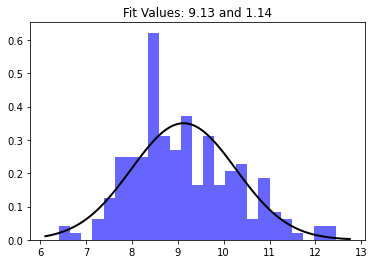

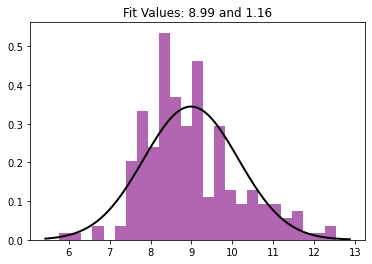

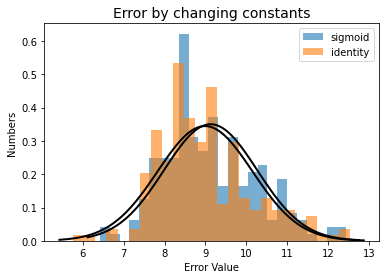

In [64]:
from scipy.stats import norm
mu_sig, std_sig = norm.fit(error_sig) 
plt.hist(error_sig, bins=25, density=True, alpha=0.6, color='b')
xmin_sig, xmax_sig = plt.xlim()
x_sig = np.linspace(xmin_sig, xmax_sig, 100)
p_sig = norm.pdf(x_sig, mu_sig, std_sig)
plt.plot(x_sig, p_sig, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu_sig, std_sig)
plt.title(title)
plt.show()

mu_id, std_id = norm.fit(error_id) 
plt.hist(error_id, bins=25, density=True, alpha=0.6, color='purple')
xmin_id, xmax_id = plt.xlim()
x_id = np.linspace(xmin_id, xmax_id, 100)
p_id = norm.pdf(x_id, mu_id, std_id)
plt.plot(x_id, p_id, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu_id, std_id)
plt.title(title)
plt.show()

fig, ax = plt.subplots()
plt.hist(error_sig, bins=25, density=True, alpha=0.6, label='sigmoid')
plt.plot(x_sig, p_sig, 'k', linewidth=2)
plt.hist(error_id, bins=25, density=True, alpha=0.6, label='identity')
plt.plot(x_id, p_id, 'k', linewidth=2)
plt.title("Error by changing constants", fontsize=14)
plt.xlabel('Error Value')
plt.ylabel('Numbers')

labels = ["sigmoid", "identity"]
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles = handles, labels = labels)
plt.show()

In [10]:
def loop(shape, numberofloop):
    return 1
print(-np.log10(abs((0.1001-0.10011)/0.1001)))

9.211339872308265


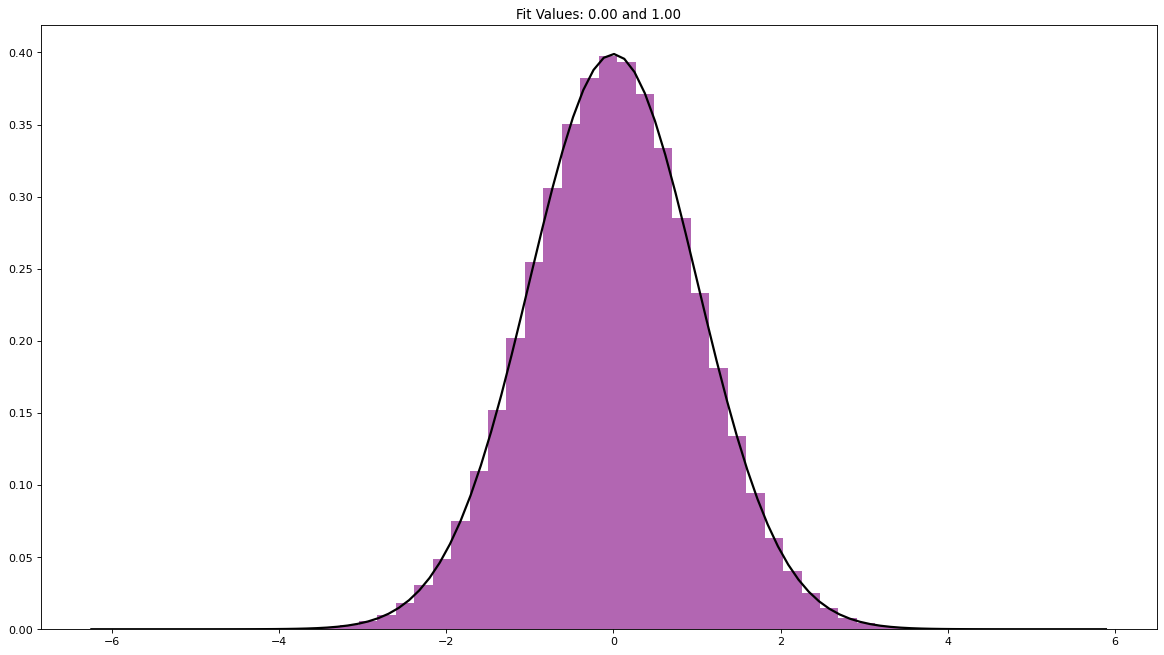

In [15]:
from scipy.stats import norm
from matplotlib.pyplot import figure

figure(figsize=(18, 10), dpi=80)
s=np.random.normal(0, 1, 100000000)
plt.hist(s, bins=50, density=True, alpha=0.6, color='purple')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0, 1)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(0, 1)
plt.title(title)
plt.show()

In [247]:
# limited integration
al = 0
be = 1
def lim_integral(dim,fix):
    if fix > 0:
        dim=dim-fix
        cons=np.dot(x.T[dim:].T,weight_input[dim:])
        if dim == 1:
            result2=[]
            for i in range(len(cons)):
                temp = []
                for l in range(k):
                    po = (polylog(dim,-np.exp(-(bias_input[l]+cons[i,l])-weight_input[0][l]*al))
                          -polylog(dim,-np.exp(-(bias_input[l]+cons[i,l])-weight_input[0][l]*be)))       
                    temp.append(weight_output[l]*((be-al)+po/weight_input[0][l]))
                result2.append((bias_output*(be-al)+sum(temp))[0])
            return result2
        else :
            temp=[]
            poly ={}
            result=[]
            for i in range(len(lims(dim)[1])):
                weight=[]
                for j in range(len(lims(dim)[0][i])):
                    arg = weight_input[j]*lims(dim)[0][i][j]
                    weight.append(arg)
                po=np.zeros((cons.shape[0],k))
                for j in range(cons.shape[0]):
                    temp2=[]
                    for l in range(k):
                        temp2.append(lims(dim)[1][i]*polylog(dim,-np.exp(-(bias_input+cons[j])-sum(weight))[l]))
                    po[j,]=np.array(temp2)
                poly[i]=po
            product=1
            for j in range(dim):
                product = product*weight_input[j]
            for l in range(len(lims(dim)[1])):
                if l == 0:
                    sumpoly=poly[l]
                else :
                    sumpoly=sumpoly+poly[l]
            for i in range(cons.shape[0]):
                result.append(float((bias_output+np.dot(1+sumpoly[i,]/product,weight_output))[0]))
        return result
    else:
        if dim == 1:
            temp = []
            for i in range(k):
                po = (polylog(dim,-np.exp(-bias_input[i]-weight_input[0][i]*al))
                      -polylog(dim,-np.exp(-bias_input[i]-weight_input[0][i]*be)))       
                temp.append(weight_output[i]*((be-al)+po/weight_input[0][i]))
            result = bias_output*(be-al)+sum(temp)
            return result[0]
        else :
            temp=[]
            poly =[]
            for i in range(len(lims(dim)[1])):
                weight=[]
                for j in range(len(lims(dim)[0][i])):
                    arg = weight_input[j]*lims(dim)[0][i][j]
                    weight.append(arg)
                po=[]
                for j in range(k):
                    po.append(lims(dim)[1][i]*polylog(dim,-np.exp(-bias_input-sum(weight))[j]))
                poly.append(np.array(po))
            product=1
            for j in range(len(weight_input)):
                product = product*weight_input[j]
            temp.append(1+sum(poly)/product)
            result=bias_output+np.dot(temp,weight_output)
        return float(result[0][0])

In [248]:
print(dim)
sy=symbolicval(dim,0)
print('Analytic_Oscil: ',sy)
weight_input, weight_output, bias_input, bias_output = coe(mlp_reg_lb)
sig_lb=integral(k,dim)
print('Sigmoid_lbsfg: ',sig_lb)
sy_f=symbolicval(dim-1,1)
print('Analytic_fix_Oscil: ',sy_f)
sig_lb_f=lim_integral(dim,1)
print('Sigmoid_lbsfg_fix: ',sig_lb_f)

3
Analytic_Oscil:  0.29002921372685075
Sigmoid_lbsfg:  0.29107399369469766
Analytic_fix_Oscil:  [0.31583884 0.25971534 0.2879265  0.312246   0.27106977 0.25710135
 0.29778461 0.31839663 0.27613278 0.29028649 0.27883901 0.25955315
 0.27781456 0.3058219  0.26287207 0.29274428 0.27891405 0.28826023
 0.27339579 0.29795895 0.25928996 0.26552618 0.31340656 0.29837291
 0.27706674 0.29688337 0.29512245 0.29313113 0.29042751 0.2877041
 0.28835427 0.27981189 0.29004899 0.27258499 0.31075857 0.26769938
 0.26678097 0.31603303 0.27093541 0.29418981 0.2910903  0.2608956
 0.28514126 0.27084401 0.30188919 0.28031258 0.27259031 0.32255469
 0.27474774 0.28922374 0.28538753 0.29046196 0.29255947 0.29545165
 0.30835755 0.32261531 0.29019665 0.31747329 0.29861718 0.2930008
 0.31781836 0.27207748 0.30605449 0.31992927 0.31151245 0.31311851
 0.27154484 0.27428456 0.26670965 0.2744719  0.30774276 0.28717248
 0.26612992 0.26167317 0.27200461 0.27039305 0.30582368 0.2783603
 0.32318513 0.28998101 0.30011388 0.2

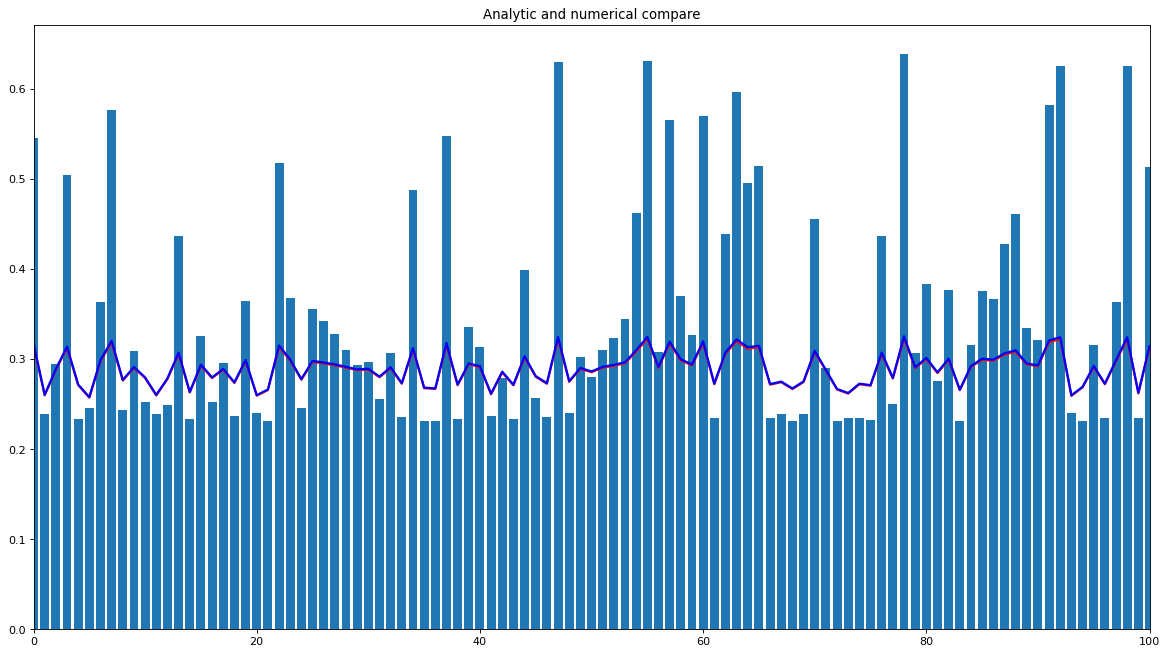

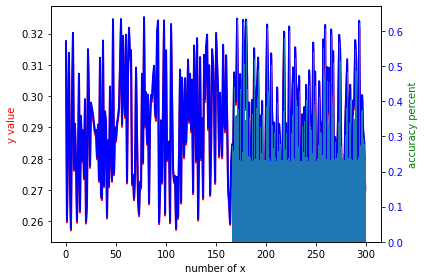

In [255]:
ratio=[]
for i in range(len(sy_f)):
    ratio.append(abs((sy_f[i]-sig_lb_f[i])/sy_f[i])*100)
    
figure(figsize=(18, 10), dpi=80)

plt.plot(list(range(len(sy_f))), sy_f, 'k', linewidth=2, color = 'red')
plt.plot(list(range(len(sy_f))), sig_lb_f, 'k', linewidth=2, color = 'blue')
plt.bar(list(range(len(sy_f))),ratio)
title = "Analytic and numerical compare"
plt.xlim(0,100)
plt.title(title)
plt.show()


fig, ax1 = plt.subplots()

ax1.set_xlabel('number of x')
ax1.set_ylabel('y value', color='red')
ax1.plot(list(range(len(sy_f))), sy_f, 'k', linewidth=2, color = 'red')
ax1.plot(list(range(len(sy_f))), sig_lb_f, 'k', linewidth=2, color = 'blue')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()  
ax2.set_ylabel('accuracy percent', color='green')  
ax2.bar(list(range(len(sy_f))),ratio)
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()
plt.show()
